In [26]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

In [27]:
sys.path.append('/home/roy/AtomCraft/install_release/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

# Creating Mesh

In [28]:
plasma_dx = 0.01
coil_dx = 0.01
vv_dx = 0.01
vac_dx = 0.06

In [29]:
with open('HBT_geom.json','r') as fid:
    HBT_geom = json.load(fid)

In [30]:
x_lim = [coord[0] for coord in HBT_geom['limiter']]
y_lim = [coord[1] for coord in HBT_geom['limiter']]

In [31]:
x_shell = [coord[0] for coord in HBT_geom['vv']['shell_cntr']]
y_shell = [coord[1] for coord in HBT_geom['vv']['shell_cntr']]

In [32]:
x_inner = [coord[0] for coord in HBT_geom['vv']['vv_inner_cntr']]
y_inner = [coord[1] for coord in HBT_geom['vv']['vv_inner_cntr']]

In [33]:
x_outer = [coord[0] for coord in HBT_geom['vv']['vv_outer_cntr']]
y_outer = [coord[1] for coord in HBT_geom['vv']['vv_outer_cntr']]

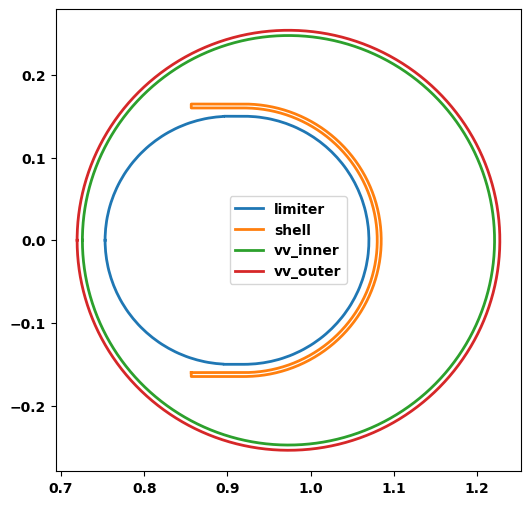

In [34]:
plt.plot(x_lim,y_lim, label='limiter')
plt.plot(x_shell, y_shell, label='shell')
plt.plot(x_inner, y_inner, label='vv_inner')
plt.plot(x_outer, y_outer, label='vv_outer')
plt.legend()

In [35]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')        # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')    # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vac_dx,'vacuum')       # Define the vacuum inside the VV
gs_mesh.define_region('shell',vv_dx,'conductor',eta=HBT_geom['vv']['eta'])  # Define the shells
gs_mesh.define_region('vv',vv_dx,'conductor',eta=HBT_geom['vv']['eta'])      # Define the VV
 
# Define each of the PF coils
for key, coil in HBT_geom['coils'].items():
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil['nturns'],coil_set=key[:2])


In [36]:
# Define geometry
gs_mesh.add_polygon(HBT_geom['limiter'][:-1],'plasma',parent_name='vacuum')
gs_mesh.add_polygon(HBT_geom['vv']['shell_cntr'],'shell',parent_name='vacuum')
gs_mesh.add_annulus(HBT_geom['vv']['vv_inner_cntr'],'vacuum', HBT_geom['vv']['vv_outer_cntr'],'vv',parent_name='air')

# Define the shape of the PF coils
for key, coil in HBT_geom['coils'].items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

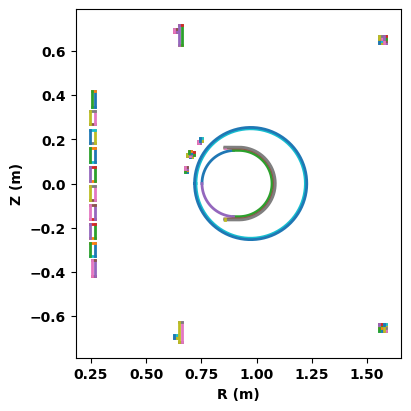

In [37]:
fig, ax = plt.subplots(1,1,figsize=(4,4),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

In [38]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 905
  # of unique segments  = 135
Generating mesh:
  # of points  = 3730
  # of cells   = 7340
  # of regions = 35


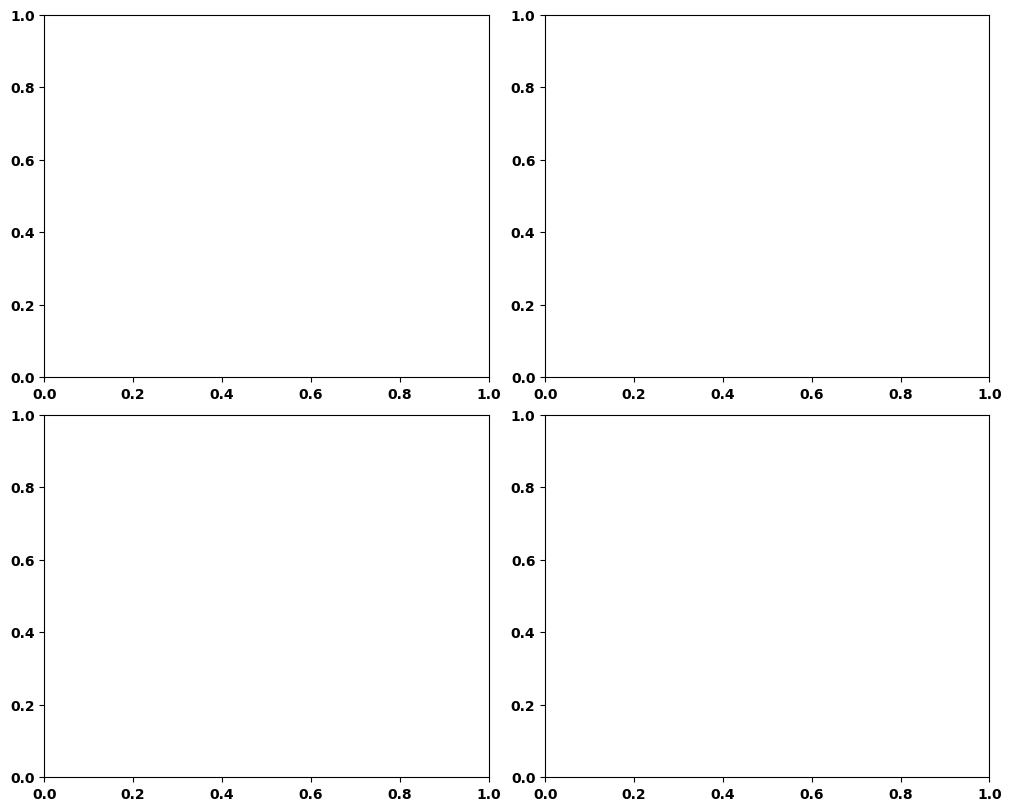

In [39]:
fig, ax = plt.subplots(2,2,figsize=(10,8),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

In [15]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'HBT_mesh.h5')

# Compute Equilibrium

In [16]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [17]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('HBT_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0=0.2518*1.23) # F0 = B0 * R0


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.278E+00
    # of points  =    3730
    # of edges   =   11069
    # of cells   =    7340
    # of boundary points =     118
    # of boundary edges  =     118
    # of boundary cells  =     118
  Resolution statistics:
    hmin =  1.959E-04
    hrms =  3.421E-02
    hmax =  9.532E-02
  Surface grounded at vertex     804


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.6659159999999999E-003


In [18]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
for name, coil in mygs.coil_sets.items():
    if name.startswith('OH'):
        bounds = [-2.00E+04,2.00E+04]
    elif name.startswith('VF'):
        bounds = [-1.50E+04,4.20E+04]
    elif name.startswith('SH'):
        bounds = [-1.50E+04,1.50E+04]
    coil_bounds[coil['id'],:] = np.array(bounds)

mygs.set_coil_bounds(coil_bounds)

In [19]:
Ip_target = 11928.5

mygs.set_targets(Ip=Ip_target, Ip_ratio=0.02)

In [20]:
isoflux_pts = np.array([
    [107.0, 0.0],
    [93.0, 14.0],
    [78.0, 0.0],
    [93.0, -14.0]
])/100.0

mygs.set_isoflux(isoflux_pts)

In [21]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-1*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

# Force shaping coil to 0
coil_reg_weights[mygs.coil_sets['SH']['id']] = 1.E3

# Set OH current to -8 kA
coil_reg_targets[mygs.coil_sets['OH']['id']] = -8.E3
coil_reg_weights[mygs.coil_sets['OH']['id']] = 1.E3

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

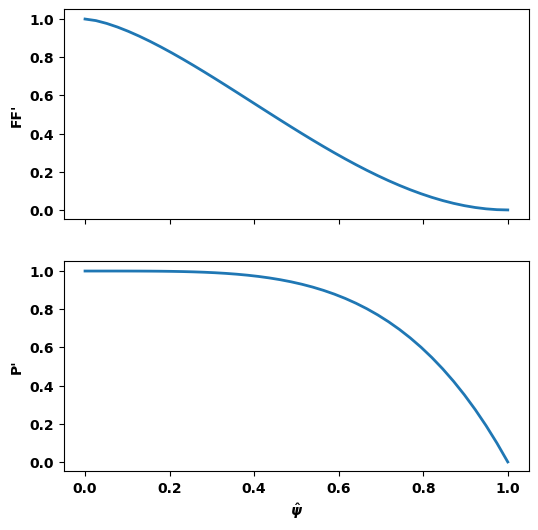

In [22]:
# Set profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [23]:
R0 = 0.92
Z0 = 0.0
a = 0.15
kappa = 1.0
delta = 0.0
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  1.9399E-02  3.1501E-01  3.0188E-04  9.3857E-01 -1.7235E-05  0.0000E+00
     2  2.0101E-02  3.2139E-01  8.0638E-05  9.3962E-01 -1.6091E-05  0.0000E+00
     3  2.0301E-02  3.2316E-01  2.2287E-05  9.3989E-01 -2.5844E-05  0.0000E+00
     4  2.0365E-02  3.2372E-01  6.5134E-06  9.3998E-01 -3.1461E-05  0.0000E+00
     5  2.0387E-02  3.2390E-01  1.9973E-06  9.4000E-01 -3.6986E-05  0.0000E+00
     6  2.0394E-02  3.2396E-01  6.3256E-07  9.4001E-01 -4.2374E-05  0.0000E+00
 Timing:   7.6615733998551150E-002
   Source:     3.8685579000230064E-002
   Solve:      3.0665076001241687E-002
   Boundary:   1.2693349981418578E-003
   Other:      5.9957439989375416E-003


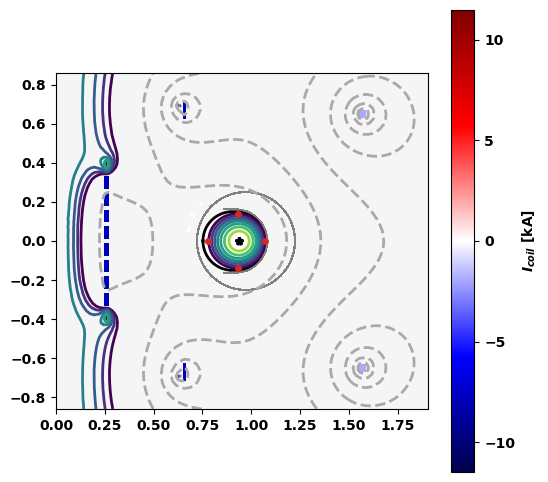

In [24]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=8)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

In [25]:
mygs.print_info()
 
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.1928E+04
  Current Centroid [m]    =    0.933 -0.000
  Magnetic Axis [m]       =    0.940 -0.000
  Elongation              =    0.969 (U:  0.969, L:  0.969)
  Triangularity           =   -0.004 (U: -0.009, L:  0.000)
  Plasma Volume [m^3]     =    0.365
  q_0, q_95               =    2.227  2.981
  Peak Pressure [Pa]      =    2.8217E+02
  Stored Energy [J]       =    6.1610E+01
  <Beta_pol> [%]          =   97.7861
  <Beta_tor> [%]          =    0.2565
  Diamagnetic flux [Wb]   =    3.6725E-07
  Toroidal flux [Wb]      =    2.1126E-02
  l_i                     =    0.7033

Coil Currents [kA]:
  OH:             -8.00
  VF:             -1.92
  SH:              0.00
